In [1]:
class ARGS():
    seed = 42
    n_folds = 5
    train_split = 0.80
    val_split = 0.2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Code Reproducibility
import random
from scipy.stats import zscore
import folium
from folium.plugins import HeatMap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,f1_score,recall_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
import pandas as pd
import numpy as np
import random
from faker import Faker
from datetime import timedelta

fake = Faker('en_IN')
Faker.seed(42)
np.random.seed(42)

indian_locations = [
    ("Mumbai", "Maharashtra", 19.0760, 72.8777), ("Delhi", "Delhi", 28.6139, 77.2090),
    ("Bengaluru", "Karnataka", 12.9716, 77.5946), ("Ahmedabad", "Gujarat", 23.0225, 72.5714),
    ("Kolkata", "West Bengal", 22.5726, 88.3639), ("Chennai", "Tamil Nadu", 13.0827, 80.2707),
    ("Hyderabad", "Telangana", 17.3850, 78.4867), ("Jaipur", "Rajasthan", 26.9124, 75.7873),
    ("Pune", "Maharashtra", 18.5204, 73.8567), ("Surat", "Gujarat", 21.1702, 72.8311),
    ("Lucknow", "Uttar Pradesh", 26.8467, 80.9462), ("Bhopal", "Madhya Pradesh", 23.2599, 77.4126),
    ("Patna", "Bihar", 25.5941, 85.1376), ("Indore", "Madhya Pradesh", 22.7196, 75.8577),
    ("Nagpur", "Maharashtra", 21.1458, 79.0882)
]

transaction_types = ["Send Money", "Receive Money", "Merchant Payment", "Bill Payment"]
sites = ["Amazon", "Flipkart", "PhonePe", "Swiggy", "IRCTC", "Zomato", "Google Play", "Ola", "Uber", "Paytm"]
device_types = ["Mobile", "Tablet", "Desktop"]
banks = ["SBI", "HDFC", "ICICI", "Axis", "Kotak", "PNB", "BOB", "Canara"]

# Weighted city distribution (simulate real traffic)
city_weights = [0.15 if city[0] in ["Mumbai", "Delhi", "Bengaluru", "Kolkata", "Chennai"] else 0.05 for city in indian_locations]

# Weighted transaction types
transaction_type_weights = [0.4, 0.2, 0.2, 0.2]  # Send Money is most frequent

# Weighted popular sites
site_weights = [0.2 if s in ["Amazon", "Flipkart"] else 0.15 if s in ["PhonePe", "Paytm"] else 0.05 for s in sites]

# Weighted banks
bank_weights = [0.25 if b in ["SBI", "ICICI"] else 0.1 for b in banks]

n_transactions = 100_000
n_users = 5000
user_ids = [fake.random_int(10000000, 99999999) for _ in range(n_users)]

# Initialize per-user data
user_data = {}
for uid in user_ids:
    income = np.random.normal(50_000, 30_000)
    income = max(income, 5000)
    user_data[uid] = {
        "income": income,
        "min_transaction": np.random.uniform(1, 500),
        "max_transaction": np.random.uniform(20_000, 5_00_000),
        "balance": np.random.uniform(10_000, 10_00_000),
        "last_device": None,
        "used_sites": set()
    }

# Generate transactions
transactions = []
start_date = pd.to_datetime("2023-01-01")

for i in range(n_transactions):
    uid = random.choice(user_ids)
    udata = user_data[uid]
    txn_value = np.random.uniform(udata['min_transaction'], udata['max_transaction'])
    txn_time = start_date + timedelta(minutes=random.randint(0, 525600))
    location = random.choices(indian_locations, weights=city_weights, k=1)[0]
    site = random.choices(sites, weights=site_weights)[0]
    lat_jitter, lon_jitter = np.random.uniform(-0.05, 0.05), np.random.uniform(-0.05, 0.05)
    latitude = round(location[2] + lat_jitter, 6)
    longitude = round(location[3] + lon_jitter, 6)

    balance = max(0, udata['balance'] - txn_value if random.random() < 0.6 else udata['balance'] + txn_value)
    device = random.choices(device_types, weights=[0.8, 0.1, 0.1])[0]

    # New flags
    device_change_flag = 1 if udata['last_device'] and device != udata['last_device'] else 0
    unusual_hour = 1 if txn_time.hour >= 0 and txn_time.hour < 5 else 0
    new_site_flag = 1 if site not in udata['used_sites'] else 0

    udata['last_device'] = device
    udata['used_sites'].add(site)

    txn = {
        "transaction_id": f"TXN{i:06d}",
        "account_number": uid,
        "transaction_time": txn_time,
        "transaction_value": round(txn_value, 2),
        "income": round(udata['income'], 2),
        "transaction_type": random.choice(transaction_types),
        "site": site,
        "balance_after_transaction": round(balance, 2),
        "city": location[0],
        "state": location[1],
        "device_type": device,
        "bank": random.choice(banks),
        "latitude": latitude,
        "longitude": longitude,
        "device_change_flag": device_change_flag,
        "unusual_hour": unusual_hour,
        "new_site_flag": new_site_flag
    }

    # Rule-based fraud label
    is_fraud = 0
    if txn["transaction_value"] > 2 * udata['income']:
        is_fraud = 1
    elif device == "Desktop" and txn["transaction_type"] == "Send Money" and random.random() < 0.3:
        is_fraud = 1
    elif random.random() < 0.002:
        is_fraud = 1

    txn["is_fraud"] = is_fraud
    transactions.append(txn)

df = pd.DataFrame(transactions)

# Adjust fraud distribution to exactly 0.1% (i.e., 100 frauds in 1 lakh rows)
df["is_fraud"] = 0
fraud_indices = np.random.choice(df.index, size=20000, replace=False)
df.loc[fraud_indices, "is_fraud"] = 1

# Save and preview
df.to_csv("enhanced_upi_dataset.csv", index=False)
print(df.head())
print("\n✅ Enhanced dataset saved as 'enhanced_upi_dataset.csv' with", len(df), "rows.")

  transaction_id  account_number    transaction_time  transaction_value  \
0      TXN000000        53868501 2023-07-24 18:54:00           31066.14   
1      TXN000001        12621269 2023-10-21 15:20:00           47133.02   
2      TXN000002        81757508 2023-12-28 16:16:00          169876.51   
3      TXN000003        13976288 2023-03-08 06:41:00          163683.11   
4      TXN000004        73995913 2023-05-23 01:50:00          118378.90   

     income  transaction_type    site  balance_after_transaction     city  \
0  36067.87        Send Money  Amazon                  777560.44  Lucknow   
1  74157.20      Bill Payment   Paytm                  138794.40   Jaipur   
2  84887.08        Send Money  Amazon                  796475.47  Lucknow   
3  28148.29  Merchant Payment  Zomato                  585271.93   Nagpur   
4  79317.90     Receive Money   IRCTC                  808586.28   Mumbai   

           state device_type   bank   latitude  longitude  device_change_flag  \
0  Ut

In [4]:
# Preview top few rows
import pandas as pd

# Load dataset
df = pd.read_csv("/Users/jalajtrivedi/iit/pytorchDL/enhanced_upi_dataset.csv")
df.head()

,transaction_id,account_number,transaction_time,transaction_value,income,transaction_type,site,balance_after_transaction,city,state,device_type,bank,latitude,longitude,device_change_flag,unusual_hour,new_site_flag,is_fraud
0,TXN000000,53868501,2023-07-24 18:54:00,31066.14,36067.87,Send Money,Amazon,777560.44,Lucknow,Uttar Pradesh,Mobile,ICICI,26.804530,80.951817,0,0,1,0
1,TXN000001,12621269,2023-10-21 15:20:00,47133.02,74157.20,Bill Payment,Paytm,138794.40,Jaipur,Rajasthan,Mobile,ICICI,26.883541,75.811822,0,0,1,0
2,TXN000002,81757508,2023-12-28 16:16:00,169876.51,84887.08,Send Money,Amazon,796475.47,Lucknow,Uttar Pradesh,Desktop,PNB,26.889029,80.913095,0,0,1,1
3,TXN000003,13976288,2023-03-08 06:41:00,163683.11,28148.29,Merchant Payment,Zomato,585271.93,Nagpur,Maharashtra,Tablet,Axis,21.104164,79.094729,0,0,1,0
4,TXN000004,73995913,2023-05-23 01:50:00,118378.90,79317.90,Receive Money,IRCTC,808586.28,Mumbai,Maharashtra,Desktop,Axis,19.064839,72.912157,0,1,1,0


In [5]:
# Check shape and basic info
print("Shape:", df.shape)
print(df.info())
print(df.describe(include='all'))

Shape: (100000, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   transaction_id             100000 non-null  object 
 1   account_number             100000 non-null  int64  
 2   transaction_time           100000 non-null  object 
 3   transaction_value          100000 non-null  float64
 4   income                     100000 non-null  float64
 5   transaction_type           100000 non-null  object 
 6   site                       100000 non-null  object 
 7   balance_after_transaction  100000 non-null  float64
 8   city                       100000 non-null  object 
 9   state                      100000 non-null  object 
 10  device_type                100000 non-null  object 
 11  bank                       100000 non-null  object 
 12  latitude                   100000 non-null  float64
 13  longitude 

In [6]:
# Check missing values
df.isnull().sum()

transaction_id               0
account_number               0
transaction_time             0
transaction_value            0
income                       0
transaction_type             0
site                         0
balance_after_transaction    0
city                         0
state                        0
device_type                  0
bank                         0
latitude                     0
longitude                    0
device_change_flag           0
unusual_hour                 0
new_site_flag                0
is_fraud                     0
dtype: int64

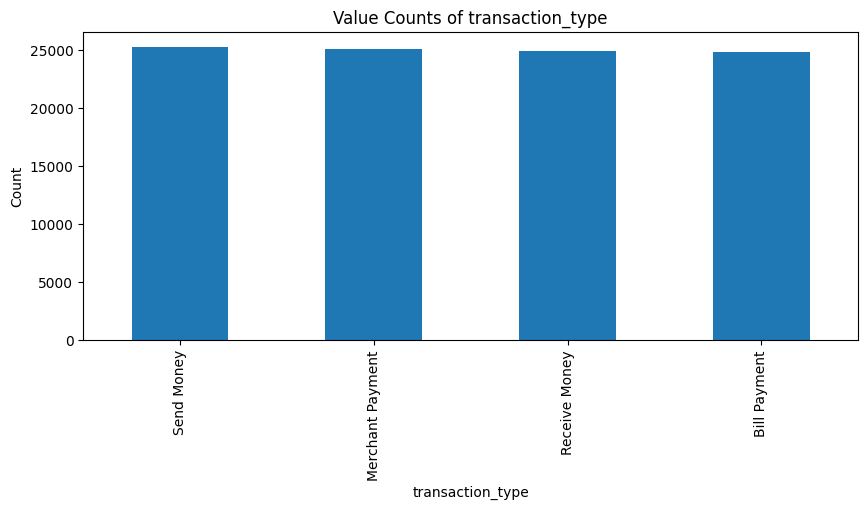

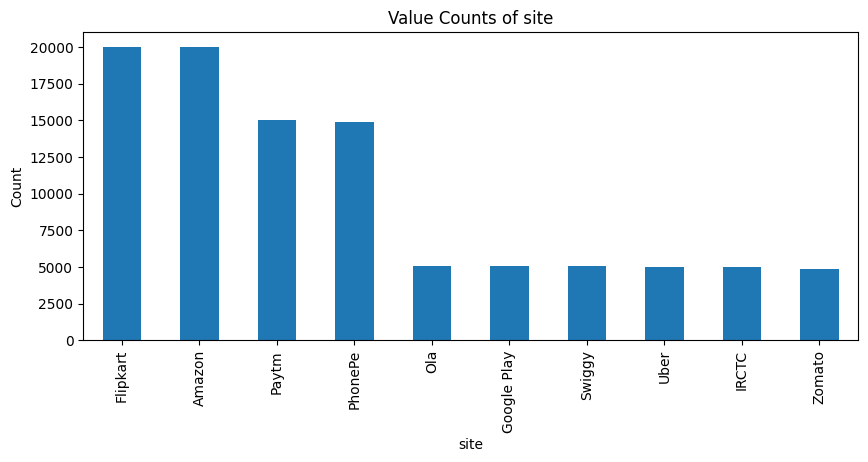

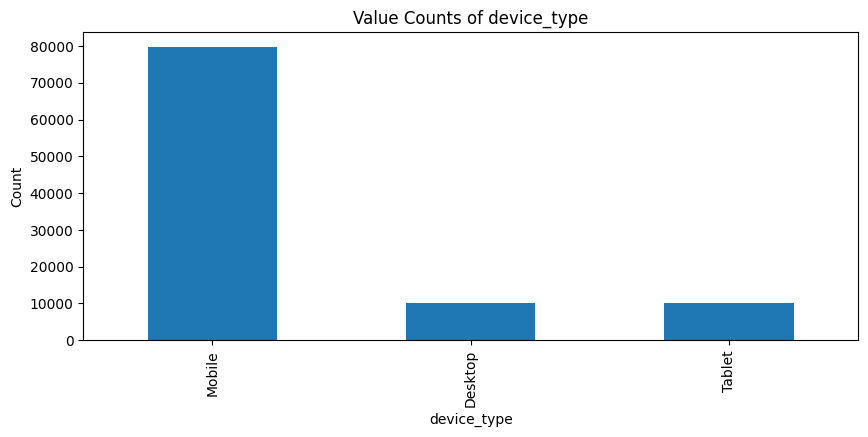

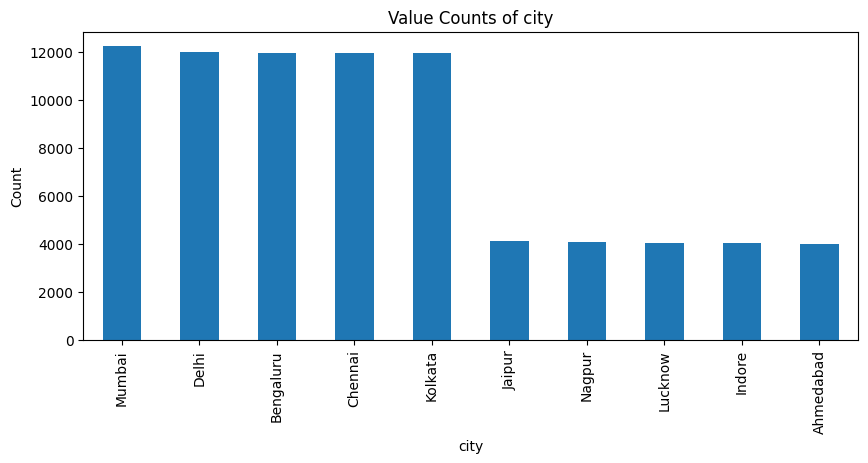

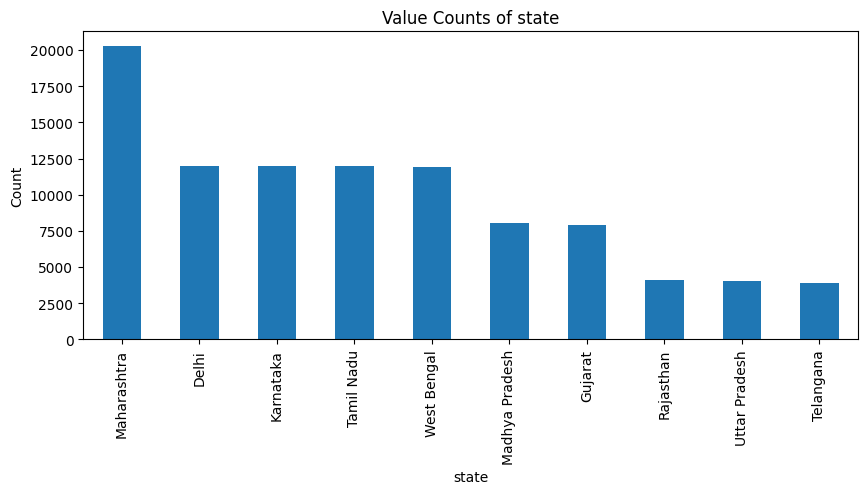

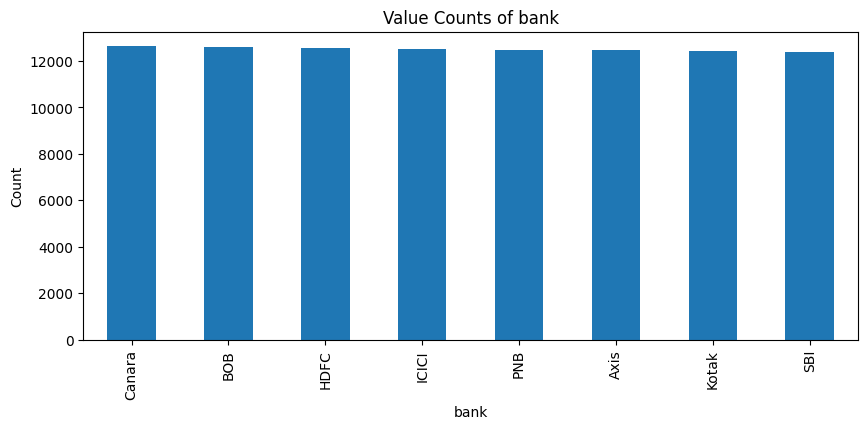

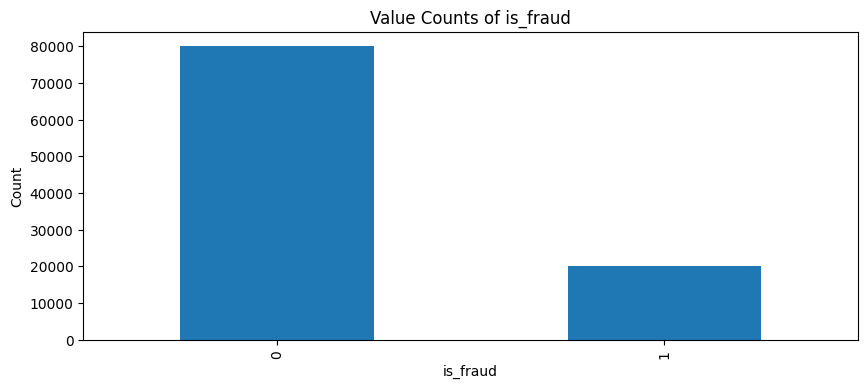

In [7]:
cat_cols = ['transaction_type', 'site', 'device_type', 'city', 'state', 'bank','is_fraud']
for col in cat_cols:
    plt.figure(figsize=(10,4))
    df[col].value_counts().head(10).plot(kind='bar')
    plt.title(f'Value Counts of {col}')
    plt.ylabel('Count')
    plt.show()

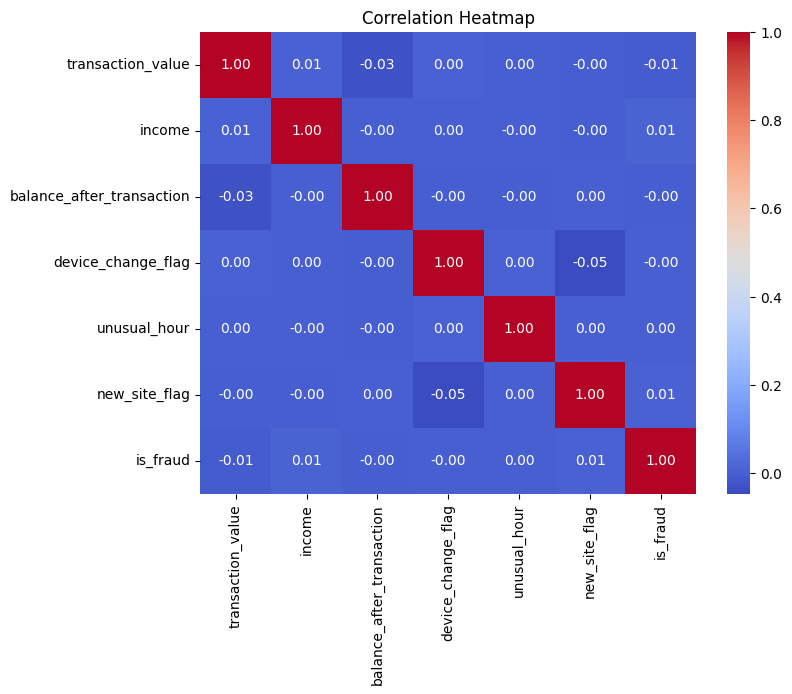

In [8]:
corr = df[["transaction_value", "income", "balance_after_transaction", "device_change_flag", "unusual_hour", "new_site_flag", "is_fraud"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

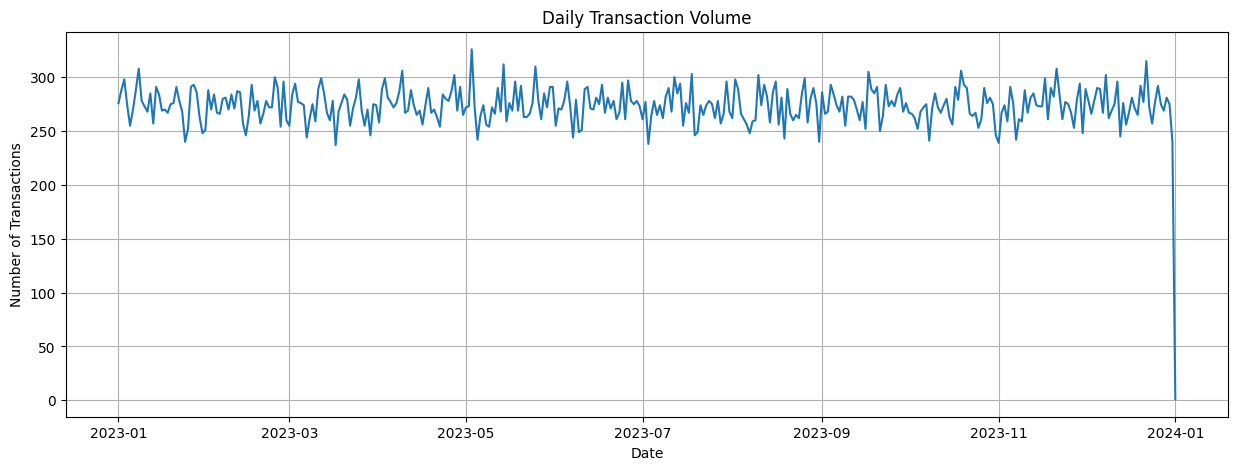

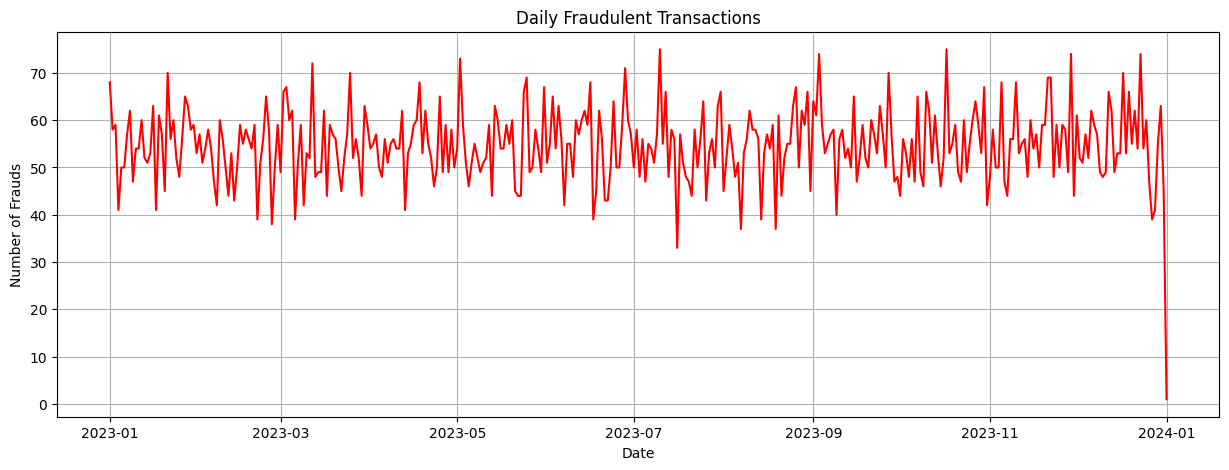

In [9]:
# Transactions over time
df['transaction_time'] = pd.to_datetime(df['transaction_time'])
df['date'] = df['transaction_time'].dt.date
txn_daily = df.groupby('date').size()

plt.figure(figsize=(15, 5))
txn_daily.plot()
plt.title("Daily Transaction Volume")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.grid()
plt.show()

# Fraud over time
fraud_daily = df[df['is_fraud'] == 1].groupby('date').size()

plt.figure(figsize=(15, 5))
fraud_daily.plot(color='red')
plt.title("Daily Fraudulent Transactions")
plt.xlabel("Date")
plt.ylabel("Number of Frauds")
plt.grid()
plt.show()

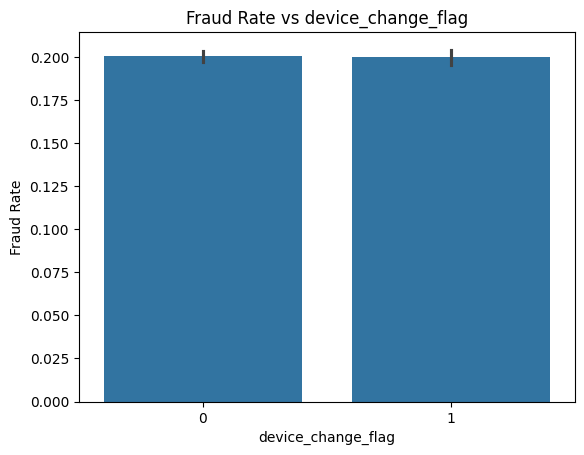

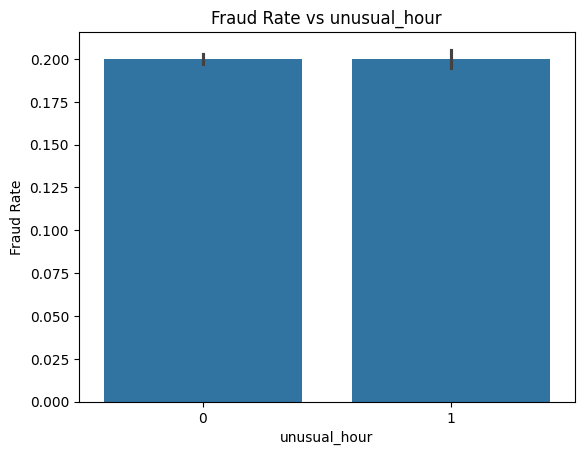

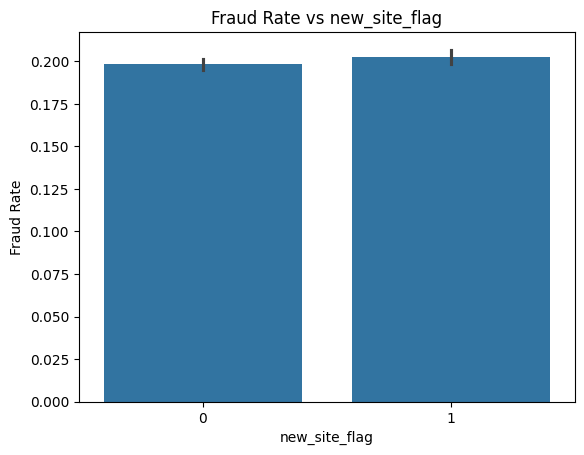

In [10]:
flags = ['device_change_flag', 'unusual_hour', 'new_site_flag']

for flag in flags:
    sns.barplot(x=flag, y='is_fraud', data=df)
    plt.title(f"Fraud Rate vs {flag}")
    plt.ylabel("Fraud Rate")
    plt.show()

In [11]:
import folium

# Create a base map centered on India
india_map = folium.Map(location=[22.9734, 78.6569], zoom_start=5)

# Filter fraud transactions
fraud_df = df[df['is_fraud'] == 1]

# Add red dots for frauds
for _, row in fraud_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=(f"City: {row['city']}<br>Site: {row['site']}<br>Amount: ₹{row['transaction_value']}"),
    ).add_to(india_map)

# Save map to HTML file
india_map.save('fraud_transactions_map.html')
print("✅ Map saved as 'fraud_transactions_map.html'")

✅ Map saved as 'fraud_transactions_map.html'


In [12]:
import webbrowser
webbrowser.open("fraud_transactions_map.html")

True

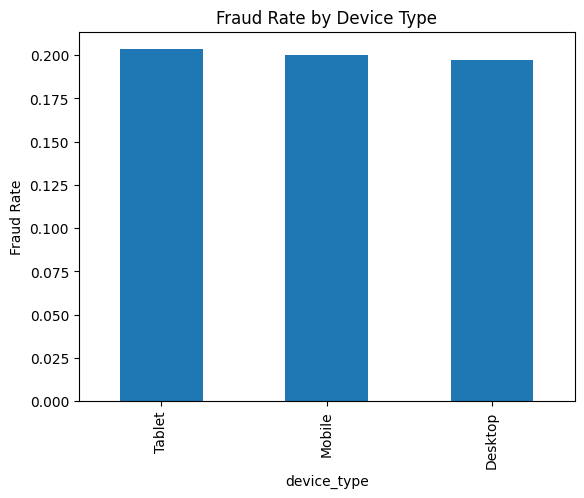

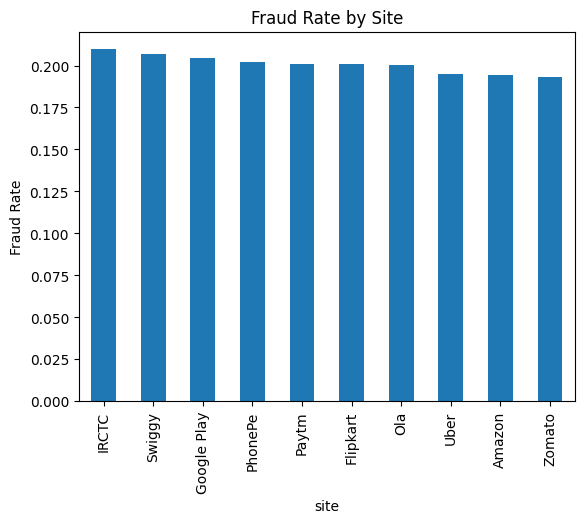

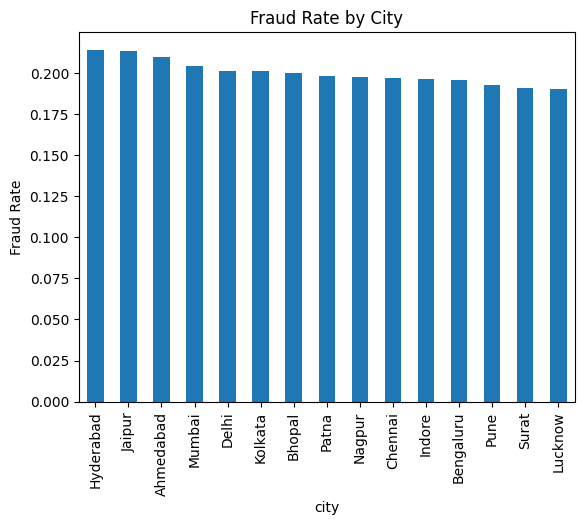

In [13]:
# Device Type
fraud_by_device = df.groupby('device_type')['is_fraud'].mean().sort_values(ascending=False)
fraud_by_device.plot(kind='bar', title='Fraud Rate by Device Type')
plt.ylabel("Fraud Rate")
plt.show()

# Site
fraud_by_site = df.groupby('site')['is_fraud'].mean().sort_values(ascending=False)
fraud_by_site.plot(kind='bar', title='Fraud Rate by Site')
plt.ylabel("Fraud Rate")
plt.show()

# City
fraud_by_city = df.groupby('city')['is_fraud'].mean().sort_values(ascending=False)
fraud_by_city.plot(kind='bar', title='Fraud Rate by City')
plt.ylabel("Fraud Rate")
plt.show()

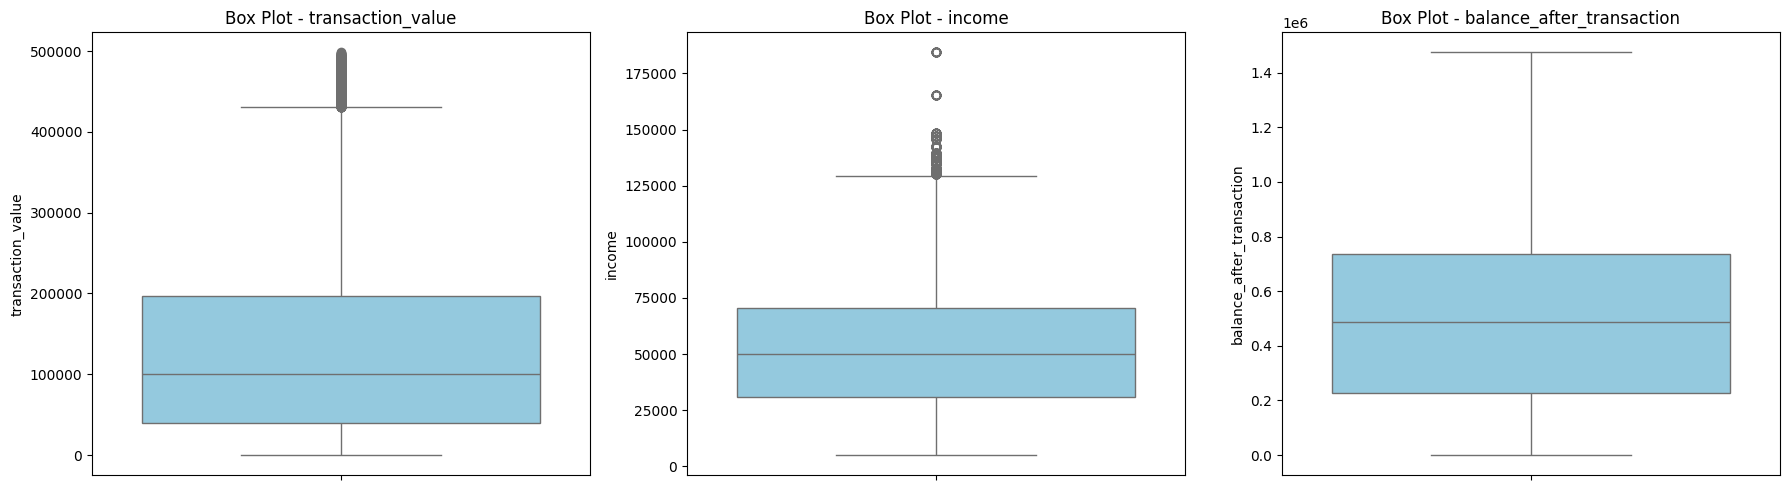

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical features for outlier detection
num_cols = ['transaction_value', 'income', 'balance_after_transaction']

plt.figure(figsize=(18, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=df, y=col, color='skyblue')
    plt.title(f'Box Plot - {col}')
plt.tight_layout()
plt.show()

In [15]:
#Feature engineering
df['transaction_hour'] = df['transaction_time'].dt.hour
df['transaction_day'] = df['transaction_time'].dt.day
df['transaction_dayofweek'] = df['transaction_time'].dt.dayofweek
df['is_weekend'] = df['transaction_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

/var/folders/n1/0lwtyv651vb22znmxz1l1sj40000gn/T/ipykernel_96548/4094802526.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_day_counts.index, y=fraud_day_counts.values, palette='Reds')


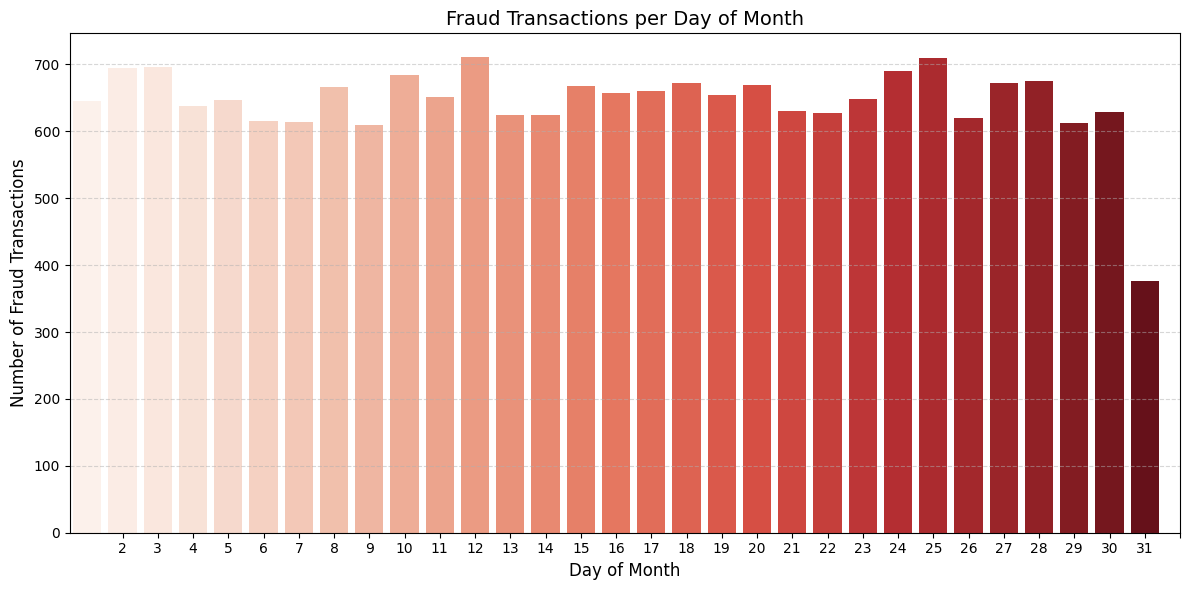

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count frauds per day
fraud_day_counts = df[df['is_fraud'] == 1]['transaction_day'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=fraud_day_counts.index, y=fraud_day_counts.values, palette='Reds')
plt.title('Fraud Transactions per Day of Month', fontsize=14)
plt.xlabel('Day of Month', fontsize=12)
plt.ylabel('Number of Fraud Transactions', fontsize=12)
plt.xticks(range(1, 32))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [17]:
df.columns

Index(['transaction_id', 'account_number', 'transaction_time',
       'transaction_value', 'income', 'transaction_type', 'site',
       'balance_after_transaction', 'city', 'state', 'device_type', 'bank',
       'latitude', 'longitude', 'device_change_flag', 'unusual_hour',
       'new_site_flag', 'is_fraud', 'date', 'transaction_hour',
       'transaction_day', 'transaction_dayofweek', 'is_weekend'],
      dtype='object')

In [18]:
columns_to_drop = ['longitude', 'latitude', 'state','date','transaction_time',
       'transaction_day', 'transaction_dayofweek']

df = df.drop(columns_to_drop, axis=1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   transaction_id             100000 non-null  object 
 1   account_number             100000 non-null  int64  
 2   transaction_value          100000 non-null  float64
 3   income                     100000 non-null  float64
 4   transaction_type           100000 non-null  object 
 5   site                       100000 non-null  object 
 6   balance_after_transaction  100000 non-null  float64
 7   city                       100000 non-null  object 
 8   device_type                100000 non-null  object 
 9   bank                       100000 non-null  object 
 10  device_change_flag         100000 non-null  int64  
 11  unusual_hour               100000 non-null  int64  
 12  new_site_flag              100000 non-null  int64  
 13  is_fraud                   100

In [20]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", MinMaxScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

In [22]:
# Model-1 Logistic Regression with HyperParameter Tunning

classifier = LogisticRegression(max_iter=1000, random_state=42)
feature_selection = SelectKBest(chi2)
# Pipeline combining preprocessing, feature selection, and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

param_grid={
    'feature_selection__k': ['all'],
    'classifier__C': [10],#, 1, 0.1],  # Regularization parameter
    'classifier__penalty': ['l1'],#, 'l2', 'elasticnet'], # Regularization type
    'classifier__solver': ['saga'],#,'liblinear'],  # Solver for optimization
    'classifier__class_weight': ['balanced']#, None]
    }

# Grid search with cross-validation
lr2 = GridSearchCV(pipeline, param_grid, cv=2, scoring='f1', verbose=3, error_score='raise')
lr2.fit(X_train, y_train)

# Get the best model and best score
best_model = lr2.best_estimator_
best_score = lr2.best_score_

print("Best Model:", best_model)
print("Best Score:", best_score)
print("Best Params:", lr2.best_params_)

# Make predictions on the validation set
y_pred = best_model.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1, classifier__solver=saga, feature_selection__k=all;, score=0.800 total time=17.9min
[CV 2/2] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1, classifier__solver=saga, feature_selection__k=all;, score=0.800 total time=17.0min
Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['account_number',
                                                   'transaction_value',
                          

/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

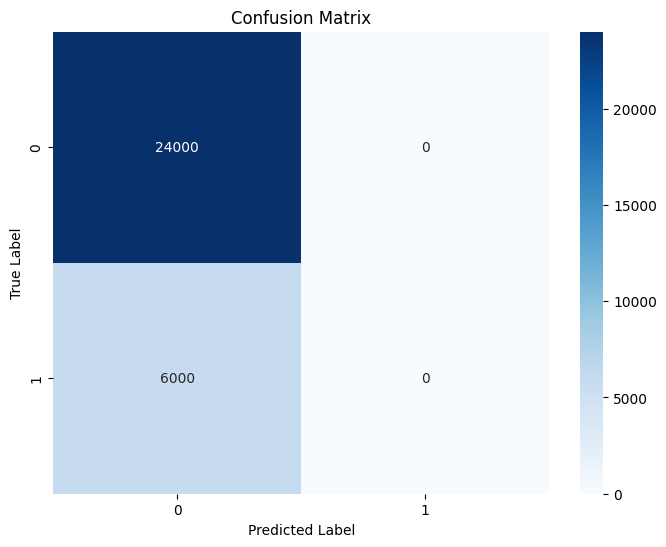

In [23]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [53]:
import pandas as pd
import numpy as np
import random
from faker import Faker
from datetime import timedelta

fake = Faker('en_IN')
Faker.seed(42)
np.random.seed(42)

indian_locations = [
    ("Mumbai", "Maharashtra", 19.0760, 72.8777), ("Delhi", "Delhi", 28.6139, 77.2090),
    ("Bengaluru", "Karnataka", 12.9716, 77.5946), ("Ahmedabad", "Gujarat", 23.0225, 72.5714),
    ("Kolkata", "West Bengal", 22.5726, 88.3639), ("Chennai", "Tamil Nadu", 13.0827, 80.2707),
    ("Hyderabad", "Telangana", 17.3850, 78.4867), ("Jaipur", "Rajasthan", 26.9124, 75.7873),
    ("Pune", "Maharashtra", 18.5204, 73.8567), ("Surat", "Gujarat", 21.1702, 72.8311),
    ("Lucknow", "Uttar Pradesh", 26.8467, 80.9462), ("Bhopal", "Madhya Pradesh", 23.2599, 77.4126),
    ("Patna", "Bihar", 25.5941, 85.1376), ("Indore", "Madhya Pradesh", 22.7196, 75.8577),
    ("Nagpur", "Maharashtra", 21.1458, 79.0882)
]

transaction_types = ["Send Money", "Receive Money", "Merchant Payment", "Bill Payment"]
sites = ["Amazon", "Flipkart", "PhonePe", "Swiggy", "IRCTC", "Zomato", "Google Play", "Ola", "Uber", "Paytm"]
device_types = ["Mobile", "Tablet", "Desktop"]
banks = ["SBI", "HDFC", "ICICI", "Axis", "Kotak", "PNB", "BOB", "Canara"]

# Weighted city distribution (simulate real traffic)
city_weights = [0.15 if city[0] in ["Mumbai", "Delhi", "Bengaluru", "Kolkata", "Chennai"] else 0.05 for city in indian_locations]

# Weighted transaction types
transaction_type_weights = [0.4, 0.2, 0.2, 0.2]  # Send Money is most frequent

# Weighted popular sites
site_weights = [0.2 if s in ["Amazon", "Flipkart"] else 0.15 if s in ["PhonePe", "Paytm"] else 0.05 for s in sites]

# Weighted banks
bank_weights = [0.25 if b in ["SBI", "ICICI"] else 0.1 for b in banks]

n_transactions = 1000
n_users = 50
user_ids = [fake.random_int(10000000, 99999999) for _ in range(n_users)]

# Initialize per-user data
user_data = {}
for uid in user_ids:
    income = np.random.normal(50_000, 30_000)
    income = max(income, 5000)
    user_data[uid] = {
        "income": income,
        "min_transaction": np.random.uniform(1, 500),
        "max_transaction": np.random.uniform(20_000, 5_00_000),
        "balance": np.random.uniform(10_000, 10_00_000),
        "last_device": None,
        "used_sites": set()
    }

# Generate transactions
transactions = []
start_date = pd.to_datetime("2023-01-01")

for i in range(n_transactions):
    uid = random.choice(user_ids)
    udata = user_data[uid]
    txn_value = np.random.uniform(udata['min_transaction'], udata['max_transaction'])
    txn_time = start_date + timedelta(minutes=random.randint(0, 525600))
    location = random.choices(indian_locations, weights=city_weights, k=1)[0]
    site = random.choices(sites, weights=site_weights)[0]
    lat_jitter, lon_jitter = np.random.uniform(-0.05, 0.05), np.random.uniform(-0.05, 0.05)
    latitude = round(location[2] + lat_jitter, 6)
    longitude = round(location[3] + lon_jitter, 6)

    balance = max(0, udata['balance'] - txn_value if random.random() < 0.6 else udata['balance'] + txn_value)
    device = random.choices(device_types, weights=[0.8, 0.1, 0.1])[0]

    # New flags
    device_change_flag = 1 if udata['last_device'] and device != udata['last_device'] else 0
    unusual_hour = 1 if txn_time.hour >= 0 and txn_time.hour < 5 else 0
    new_site_flag = 1 if site not in udata['used_sites'] else 0

    udata['last_device'] = device
    udata['used_sites'].add(site)

    txn = {
        "transaction_id": f"TXN{i:06d}",
        "account_number": uid,
        "transaction_time": txn_time,
        "transaction_value": round(txn_value, 2),
        "income": round(udata['income'], 2),
        "transaction_type": random.choice(transaction_types),
        "site": site,
        "balance_after_transaction": round(balance, 2),
        "city": location[0],
        "state": location[1],
        "device_type": device,
        "bank": random.choice(banks),
        "latitude": latitude,
        "longitude": longitude,
        "device_change_flag": device_change_flag,
        "unusual_hour": unusual_hour,
        "new_site_flag": new_site_flag
    }

    # Rule-based fraud label
    is_fraud = 0
    if txn["transaction_value"] > 2 * udata['income']:
        is_fraud = 1
    elif device == "Desktop" and txn["transaction_type"] == "Send Money" and random.random() < 0.3:
        is_fraud = 1
    elif random.random() < 0.002:
        is_fraud = 1

    txn["is_fraud"] = is_fraud
    transactions.append(txn)

df = pd.DataFrame(transactions)

# Adjust fraud distribution to exactly 0.1% (i.e., 100 frauds in 1 lakh rows)
df["is_fraud"] = 0
fraud_indices = np.random.choice(df.index, size=500, replace=False)
df.loc[fraud_indices, "is_fraud"] = 1

# Save and preview
df.to_csv("Minimised_Dataset_enhanced_upi_dataset.csv", index=False)
print(df.head())
print("\n✅ Enhanced dataset saved as 'Minimised_Dataset_enhanced_upi_dataset.csv' with", len(df), "rows.")

  transaction_id  account_number    transaction_time  transaction_value  \
0      TXN000000        97226012 2023-01-19 04:00:00            1400.49   
1      TXN000001        55176955 2023-12-16 00:53:00          176412.50   
2      TXN000002        39958838 2023-08-14 10:09:00          114132.39   
3      TXN000003        23718431 2023-01-03 06:20:00          255797.54   
4      TXN000004        89254563 2023-12-07 07:51:00          177367.51   

     income  transaction_type      site  balance_after_transaction       city  \
0  48925.22      Bill Payment   PhonePe                   33764.45  Bengaluru   
1  44229.17     Receive Money   PhonePe                  809381.45  Bengaluru   
2   5000.00      Bill Payment  Flipkart                  258565.83  Ahmedabad   
3  59046.42        Send Money   PhonePe                 1019800.96     Jaipur   
4  74676.35  Merchant Payment  Flipkart                  373875.67  Bengaluru   

       state device_type    bank   latitude  longitude  device

In [54]:
df = pd.read_csv("/Users/jalajtrivedi/iit/pytorchDL/Minimised_Dataset_enhanced_upi_dataset.csv")

In [55]:
#Feature engineering
df['transaction_time'] = pd.to_datetime(df['transaction_time'])
df['transaction_hour'] = df['transaction_time'].dt.hour
df['transaction_day'] = df['transaction_time'].dt.day
df['transaction_dayofweek'] = df['transaction_time'].dt.dayofweek
df['is_weekend'] = df['transaction_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

In [56]:
columns_to_drop = ['longitude', 'latitude', 'state','transaction_time',
       'transaction_day', 'transaction_dayofweek']

df = df.drop(columns_to_drop, axis=1)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             1000 non-null   object 
 1   account_number             1000 non-null   int64  
 2   transaction_value          1000 non-null   float64
 3   income                     1000 non-null   float64
 4   transaction_type           1000 non-null   object 
 5   site                       1000 non-null   object 
 6   balance_after_transaction  1000 non-null   float64
 7   city                       1000 non-null   object 
 8   device_type                1000 non-null   object 
 9   bank                       1000 non-null   object 
 10  device_change_flag         1000 non-null   int64  
 11  unusual_hour               1000 non-null   int64  
 12  new_site_flag              1000 non-null   int64  
 13  is_fraud                   1000 non-null   int64 

In [58]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", MinMaxScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

In [60]:
# Model-1 Logistic Regression with HyperParameter Tunning

classifier = LogisticRegression(max_iter=1000, random_state=42)
feature_selection = SelectKBest(chi2)
# Pipeline combining preprocessing, feature selection, and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

param_grid={
    'feature_selection__k': ['all'],
    'classifier__C': [10],#, 1, 0.1],  # Regularization parameter
    'classifier__penalty': ['l1'],#, 'l2', 'elasticnet'], # Regularization type
    'classifier__solver': ['saga'],#,'liblinear'],  # Solver for optimization
    'classifier__class_weight': ['balanced']#, None]
    }

# Grid search with cross-validation
lr2 = GridSearchCV(pipeline, param_grid, cv=2, scoring='f1', verbose=3, error_score='raise')
lr2.fit(X_train, y_train)

# Get the best model and best score
best_model = lr2.best_estimator_
best_score = lr2.best_score_

print("Best Model:", best_model)
print("Best Score:", best_score)
print("Best Params:", lr2.best_params_)

# Make predictions on the validation set
y_pred = best_model.predict(X_val)

# Print classification report (decoded labels)
print(classification_report(y_val, y_pred))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/2] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1, classifier__solver=saga, feature_selection__k=all;, score=0.503 total time=   0.5s


/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1, classifier__solver=saga, feature_selection__k=all;, score=0.473 total time=   0.4s
Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['account_number',
                                                   'transaction_value',
                                                   'income',
                                                   'balance_after_transaction',
                                                   'device_change_flag',
                                            

/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


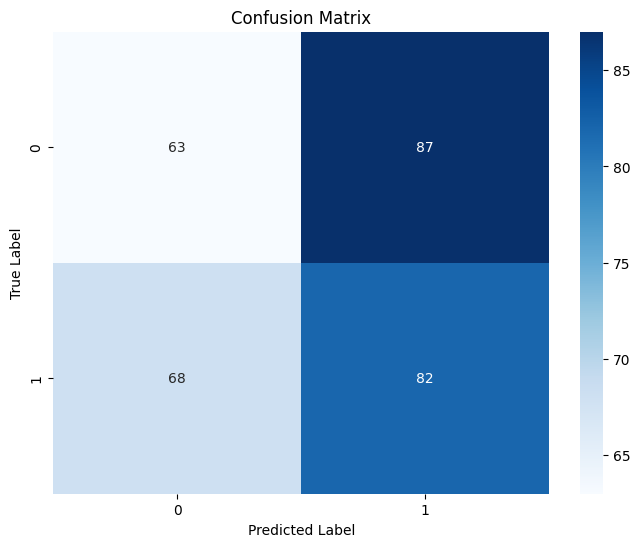

In [61]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.6.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.0 when using version 1


Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Classification Report:
               precision    recall  f1-score   support

           0     0.4762    0.6000    0.5310       100
           1     0.4595    0.3400    0.3908       100

    accuracy                         0.4700       200
   macro avg     0.4678    0.4700    0.4609       200
weighted avg     0.4678    0.4700    0.4609       200



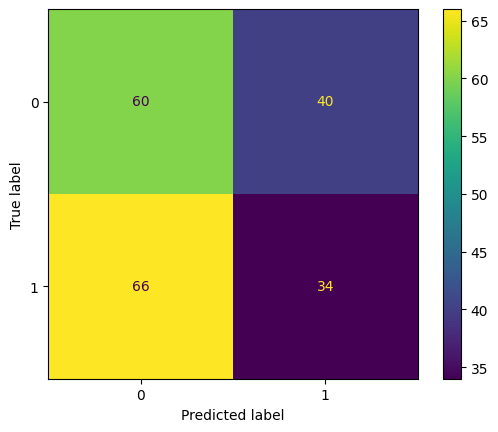

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# ---- Assuming df is your DataFrame, and X, y are defined ----

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('classifier', ExtraTreesClassifier(class_weight='balanced', random_state=42))
])

# Hyperparameter tuning grid
param = {
    'feature_selection__k': ['all'],
    'classifier__n_estimators': [120],
    'classifier__max_depth': [None],
    'classifier__min_samples_split': [3],
    'classifier__min_samples_leaf': [1],
    'classifier__bootstrap': [False],
    'classifier__criterion': ['gini'],
    'classifier__max_features': ['sqrt'],
    'classifier__class_weight': [None],
    'classifier__random_state': [42],
    'classifier__verbose': [0],
    'classifier__warm_start': [False],
    'classifier__min_weight_fraction_leaf': [0.0],  # Additional Random Forest parameters
    'classifier__ccp_alpha': [0.0]
}


grid_search = GridSearchCV(
    pipeline,
    param_grid=params,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Predict on validation
y_pred = grid_search.predict(X_val)

# Evaluation
print("\nBest Parameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_val, y_pred, digits=4))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)


AUC Score: 0.4628


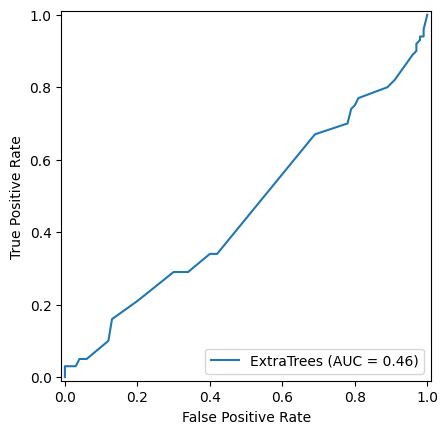

In [66]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Get predicted probabilities for the positive class
y_proba = grid_search.predict_proba(X_val)[:, 1]  # assuming binary classification, class "1" is positive

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

# Display AUC score
print(f"\nAUC Score: {roc_auc:.4f}")

# Plot ROC Curve
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ExtraTrees').plot()


Average Precision Score (PR AUC): 0.5070


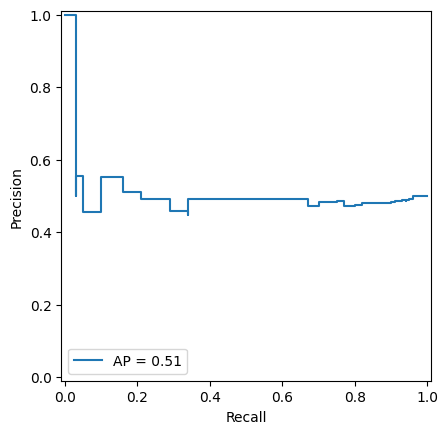

In [67]:
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay

# Get predicted probabilities for class 1 (fraud)
y_scores = grid_search.predict_proba(X_val)[:, 1]

# Compute precision-recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

# Compute average precision score
avg_precision = average_precision_score(y_val, y_scores)
print(f"\nAverage Precision Score (PR AUC): {avg_precision:.4f}")

# Plot the Precision-Recall curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=avg_precision)
disp.plot()